In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib import colors
from matplotlib.colors import ListedColormap, BoundaryNorm
import math
import copy
import xarray

from collections import Counter

import pickle
import json
import seaborn as sns
from scipy import stats

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from datetime import datetime, timedelta
import traceback

import os
from netCDF4 import Dataset
import netCDF4

import shutil

In [2]:
'''
Strategy for this entire file:
- Purpose: want to compare relative humidty bias (relative to ERA5) for IITM and ECMWF. So, in the end, we want to have two plots:
    iitm_rh - era5_rh
    ecmwf_rh - era5_rh
    and we want to compare the two plots side by side.
- Strategy:
    1. For IITM vs ERA5:
        a. Need to 'prepare' the ERA5 data. We have basically X number of systems in the IITM forecast, given in the file 'IITM_rh_bias_dates.dat'.
            For each of those systems, we want to go into the RH data for ECMWF and grab the 10 days worth of data that correspond to 
            the system (since initialization time for IITM was only at 00:00 UTC, start timestamp will always be start date at 00:00, and
            end timestamp will always be start date + 10 days + 1 day at 00:03 UTC (adding an extra day bc the slice function is
            exclusive of the last index. So this will get everything from start day 00:00 to start day + 10 days 24:00 i.e. start day
            + 11 days 00:00))
            
            Then, for each ten-day slice, write it to my home directory as a new file. Then use cdo (after running module load cdo in the
            command line), following instructions detailed below, to get an average RH file. Then plot this.
            
        b. Can directly plot IITM data using 'All_timestep.nc', prepared kindly by Vishnu.
        
    2. For ECMWF vs ERA5:
        a. Need to 'prepare' the ERA5 data in a similar way as described above; dates will be different because for the same storm,
            ECMWF and IITM may have predicted different start dates.
        b. For ECMWF data, ten-day slices as nc files are already nicely prepared (from back when we ran tempestextremes). 
            Just follow directions below.
'''

"\nStrategy for this entire file:\n- Purpose: want to compare relative humidty bias (relative to ERA5) for IITM and ECMWF. So, in the end, we want to have two plots:\n    iitm_rh - era5_rh\n    ecmwf_rh - era5_rh\n    and we want to compare the two plots side by side.\n- Strategy:\n    1. For IITM vs ERA5:\n        a. Need to 'prepare' the ERA5 data. We have basically X number of systems in the IITM forecast, given in the file 'IITM_rh_bias_dates.dat'.\n            For each of those systems, we want to go into the RH data for ECMWF and grab the 10 days worth of data that correspond to \n            the system (since initialization time for IITM was only at 00:00 UTC, start timestamp will always be start date at 00:00, and\n            end timestamp will always be start date + 10 days + 1 day at 00:03 UTC (adding an extra day bc the slice function is\n            exclusive of the last index. So this will get everything from start day 00:00 to start day + 10 days 24:00 i.e. start day\n  

# IITM vs ERA5 ten day

## prepare the ERA5 data to be plotted

In [3]:
#figure out which dates all the 10-day forecasts start at
f = open('IITM_rh_bias_dates.dat', 'r')
lines = f.readlines()
f.close()

dates = []
for element in lines:
    date = element[:8]
    dates.append(date)

In [4]:
print(len(dates))

148


In [5]:
#for going back later and making sure all the files that should be there are actually there
allfiledates = []
for file in sorted(os.listdir("/global/cscratch1/sd/salilg/rh_era5_iitm_tenday/")):
    if file.startswith('slice'):
        filedate = file[6:14]
        allfiledates.append(filedate)

In [6]:
#for date in dates:
 #   if date not in allfiledates:
  #      print(date)

In [7]:
#takes an input day and returns the date ten days later
def moveTenDays(date):
    year = date[0:4]
    month = date[4:6]
    day = date[6:8]
    startDate = datetime(int(year), int(month), int(day))
    d = timedelta(days=10)
    return startDate + d

In [8]:
'''
#ERROR BELOW: ERA5 is hourly data, so the last day timestep should really be at 'T00:00'. The reason IITM was 'T03:00' was because 
IITM has 3 hours timesteps, not hourly...
'''

"\n#ERROR BELOW: ERA5 is hourly data, so the last day timestep should really be at 'T00:00'. The reason IITM was 'T03:00' was because \nIITM has 3 hours timesteps, not hourly...\n"

In [35]:
#this is for the rest of the years; ONLY DO IT ONCE; HAS ALREADY BEEN DONE
#not using runningTotal; instead, just writing each ten day slice as a netcdf file then averaging in command line using cdo
'''years = ['2014'] #will probably need to do this one by one because it does it really slowly for each year

for year in years:
    
    file = '/global/project/projectdirs/m3310/vishnu/LPS_detetction_data/ERA5/rh850_' + year + '.nc'
    ds = xarray.open_dataset(file)
    
    for date in dates:
        if date == '20140915':
            #if date != dates[0] and date[:4] == year:

            firstDay = date
            lastDay = moveTenDays(firstDay)

            firstDayForSlicing = firstDay[:4] + '-' + firstDay[4:6] + '-' + firstDay[6:8] + 'T00:00'
            lastDayForSlicing = str(lastDay.year) + '-' + str(lastDay.month).zfill(2) + '-' + str(lastDay.day).zfill(2) + 'T03:00'

            tenDaySlice = ds.sel(time=slice(firstDayForSlicing, lastDayForSlicing))
            %time tenDaySlice.to_netcdf("/global/cscratch1/sd/salilg/rh_era5_tenday/slice_" + date + ".nc", 'w')
            #runningTotal = xarray.merge([runningTotal, tenDaySlice]) #DON'T DO THIS LINE. USE CDO, specified below.4
            
    ds.close()'''
    

CPU times: user 2.47 s, sys: 1min 32s, total: 1min 34s
Wall time: 1min 51s


## plot the data

In [ ]:
'''
NOTE:
- to get output_slice_averaged.nc, the following was done in the command line:
    1. cdo ensmean slice_20070619.nc slice_20070624.nc ... slice_20180916.nc output_slice.nc [where output_slice.nc is the output file]
    2. cdo ensmean output_slice.nc slice_20070618.nc slice_20140915.nc output_slice_updated.nc [these two were missed for some reason]
    3. cdo timmean output_slice_updated.nc output_slice_averaged.nc
'''

In [8]:
era5_iitm_ds = xarray.open_dataset("/global/cscratch1/sd/salilg/rh_era5_iitm_tenday/output_slice_averaged.nc")
#lats = era5dataset.variables['lat'][:]
#lons = era5dataset.variables['lon'][:]
#era5_rh = era5dataset.variables['RH'][:,:,:][0]
era5_iitm_ds.close()

In [9]:
#because the IITM data is not for the whole world, just for a large rectangle around India, need to select only that area of ERA5
era5_iitm_ds_new = era5_iitm_ds.sel(lon = slice(40, 120)).sel(lat = slice(40, -30))
#era5_ds_new

In [10]:
era5_iitm_lats = era5_iitm_ds_new.lat
era5_iitm_lons = era5_iitm_ds_new.lon
era5_iitm_rh = era5_iitm_ds_new.RH[0]

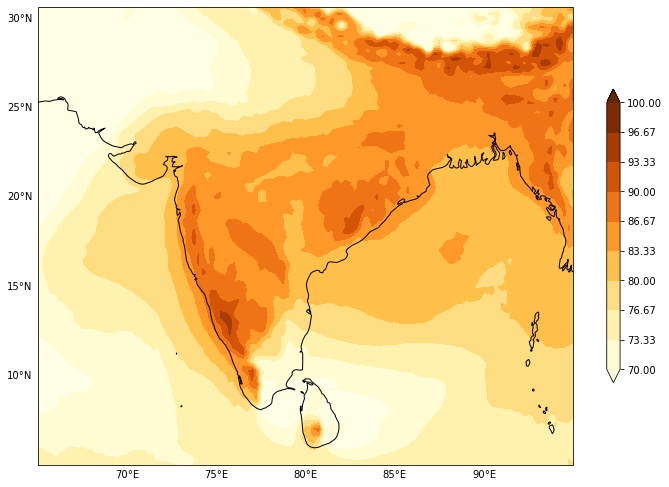

In [12]:
figure = plt.figure(figsize=[12, 12])

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
#ax.set_extent(axisExtent)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines =False
ax.set_extent([65,95,5,30])

#ax.contour(lons, lats, era5_rh, vmax = 90)
v = np.linspace(70, 100, 10, endpoint=True)
var_fill = ax.contourf(era5_iitm_lons, era5_iitm_lats, era5_iitm_rh, v, cmap = plt.cm.YlOrBr, extend = 'both',
                       transform=ccrs.PlateCarree(),
                       )
plt.colorbar(var_fill, shrink = .45)

In [11]:
iitm_ds = xarray.open_dataset("All_timestep.nc")
iitm_lats = iitm_ds.latitude
iitm_lons = iitm_ds.longitude
iitm_rh = iitm_ds.RH_850mb[0]
iitm_ds.close()

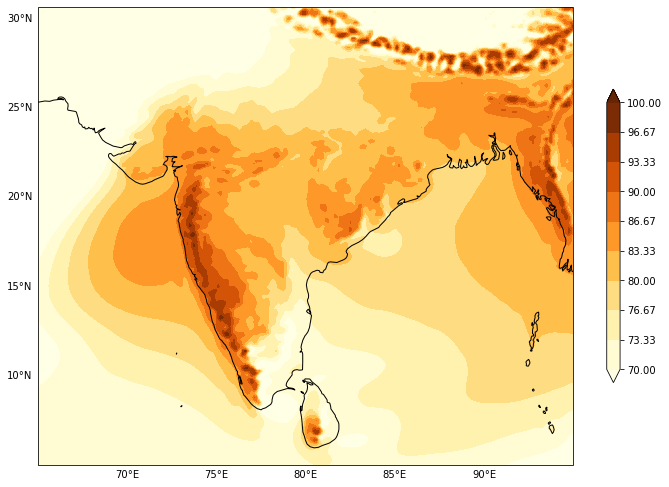

In [14]:
figure = plt.figure(figsize=[12, 12])

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
#ax.set_extent(axisExtent)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines =False
ax.set_extent([65,95,5,30])

v = np.linspace(70, 100, 10, endpoint=True)
var_fill = ax.contourf(iitm_lons, iitm_lats, iitm_rh, v, cmap = plt.cm.YlOrBr, extend = 'both',
                       transform=ccrs.PlateCarree(),
                       )
plt.colorbar(var_fill, shrink = .45)

In [12]:
iitm_rh = iitm_rh.rename({'longitude': 'lon','latitude': 'lat'})

In [13]:
iitm_rh_interpolated = iitm_rh.interp_like(era5_iitm_rh)

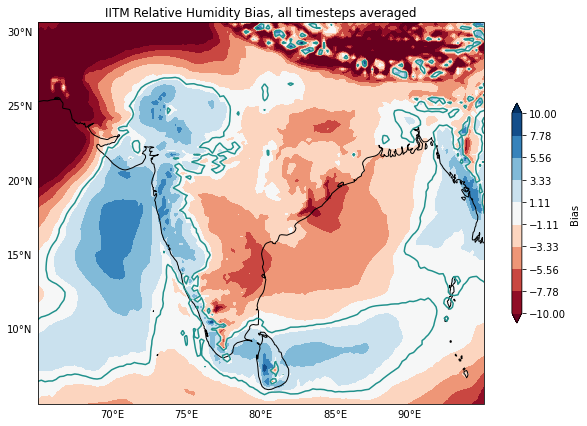

In [14]:
figure = plt.figure(figsize=[10, 9])

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines =False
ax.set_extent([65,95,5,30])

ax.contour(era5_iitm_lons, era5_iitm_lats, iitm_rh_interpolated - era5_iitm_rh, 0, extend ='both')
v = np.linspace(-10, 10, 10, endpoint=True)
var_fill = ax.contourf(era5_iitm_lons, era5_iitm_lats, iitm_rh_interpolated - era5_iitm_rh, v, cmap = plt.cm.RdBu, extend = 'both',
                       transform=ccrs.PlateCarree(),
                       )
plt.colorbar(var_fill, shrink = .45).set_label('Bias')

ax.set_title('IITM Relative Humidity Bias, all timesteps averaged')


# ECMWF vs ERA5 ten day

In [ ]:
'''
STRATEGY
- Current available data:
    - we have a dictionary called newScripts/Genesis_genFor.txt (or newScripts/ecmwf_149_iitm_158_data/Genesis_genFor.txt) that stores
        information for all the systems that we analyzed for ECMWF. The former has the 135 systems that were in the intersection of ecmwf
        and iitm systems. The latter has all 149 systems for emcwf.
    - we also have rh_data_(date) files that correspond to exactly all of those dates. 
- So, we can do through and get all the rh_data_(date) files that we need, and time-average them.
- Then, we can find the intial timestamps and go get the corresponding ECMWF data.
'''

In [15]:
with open("newScripts/ecmwf_149_iitm_158_data/Genesis_genFor.txt", "r") as handle:
    genFor = json.load(handle)

In [16]:
with open("newScripts/ecmwf_149_iitm_158_data/Genesis_genObs.txt", "r") as handle:
    genObs = json.load(handle)

In [17]:
print(len(genFor))
print(genFor['20070617'])

149
none closeby


In [18]:
file = '/global/cscratch1/sd/salilg/2007/rh_data_20070618.nc'
%time ds = xarray.open_dataset(file)
ds.close()

CPU times: user 71.3 ms, sys: 35.3 ms, total: 107 ms
Wall time: 170 ms


## prepare the ecmwf data

In [20]:
#intialize runningTotalECMWF_track using the first date

#first copy all the rh files to a separate directory
'''for date in genFor:
    if date[:4] != '2019':
        file = '/global/cscratch1/sd/salilg/' + date[:4] + '/rh_data_' + date + '.nc'
        shutil.copy2(file, '/global/cscratch1/sd/salilg/rh_era5_ecmwf_tenday/')'''
        
'''
NOW: go into the command line and run the following:
    1. cdo ensmean rh_data_* output_slice_ecmwf.nc [where output_slice.nc is the output file]
    2. cdo timmean output_slice_ecmwf.nc output_slice_averaged_ecmwf.nc
'''

#ECMWF data is now ready to plot

## prepare the era5 data corresponding to this ecmwf data

In [19]:
#genObs[key] = valueArray for some key e.g. '20070617' where valueArray takes a form like ['2007 06 18 00', 63.75, 20.0]
def convertGenObsToDate(valueArray):
    date = valueArray[0]
    return date[:4] + date[5:7] + date[8:10], date[11:]

In [20]:
def getLastHour(firstHour):
    return str(int(firstHour) + 3).zfill(2)

In [21]:
date = genObs['20070617'][0]
date[:4] + date[5:7] + date[8:10], date[11:]
#getLastHour(date[11:])

('20070618', '00')

In [22]:
moveTenDays('20070617')

datetime.datetime(2007, 6, 27, 0, 0)

In [69]:
#test cell

firstDay, firstHour = convertGenObsToDate(genObs['20070617'])
lastDay = moveTenDays(firstDay)
lastHour = getLastHour(firstHour)

firstDayForSlicing = firstDay[:4] + '-' + firstDay[4:6] + '-' + firstDay[6:8] + 'T' + firstHour + ':00'
lastDayForSlicing = str(lastDay.year) + '-' + str(lastDay.month).zfill(2) + '-' + str(lastDay.day).zfill(2) + 'T' + lastHour + ':00'

file = '/global/project/projectdirs/m3310/vishnu/LPS_detetction_data/ERA5/rh850_2007.nc'
%time ds = xarray.open_dataset(file)
%time tenDaySlice = ds.sel(time=slice(firstDayForSlicing, lastDayForSlicing))
ds.close()

CPU times: user 14.1 ms, sys: 62.4 ms, total: 76.5 ms
Wall time: 14.3 s
CPU times: user 5.6 ms, sys: 1.87 ms, total: 7.47 ms
Wall time: 18.1 ms


In [71]:
#runningTotal

In [124]:
#ONLY DO THIS ONCE; HAS ALREADY BEEN DONE

years = ['2014', '2015', '2016', '2017', '2018']

'''for year in years:
    
    file = '/global/project/projectdirs/m3310/vishnu/LPS_detetction_data/ERA5/rh850_' + year + '.nc'
    ds = xarray.open_dataset(file)
    
    for date in genObs:
        if date in genFor and date[:4] == year and int(date[4:]) < 920:

            firstDay, firstHour = convertGenObsToDate(genObs[date])
            lastDay = moveTenDays(firstDay)
            lastHour = getLastHour(firstHour)

            firstDayForSlicing = firstDay[:4] + '-' + firstDay[4:6] + '-' + firstDay[6:8] + 'T' + firstHour + ':00'
            lastDayForSlicing = str(lastDay.year) + '-' + str(lastDay.month).zfill(2) + '-' + str(lastDay.day).zfill(2) + 'T' + lastHour + ':00'

            tenDaySlice = ds.sel(time=slice(firstDayForSlicing, lastDayForSlicing))
            %time tenDaySlice.to_netcdf("/global/cscratch1/sd/salilg/rh_era5_ecmwf_tenday/era5_for_ecmwf_rh_files/slice_" + date + ".nc", 'w')
            #runningTotal = xarray.merge([runningTotal, tenDaySlice])
            
    ds.close()'''

#DOn't NEED TO DO

'for year in years:\n    \n    file = \'/global/project/projectdirs/m3310/vishnu/LPS_detetction_data/ERA5/rh850_\' + year + \'.nc\'\n    ds = xarray.open_dataset(file)\n    \n    for date in genObs:\n        if date in genFor and date[:4] == year and int(date[4:]) < 920:\n\n            firstDay, firstHour = convertGenObsToDate(genObs[date])\n            lastDay = moveTenDays(firstDay)\n            lastHour = getLastHour(firstHour)\n\n            firstDayForSlicing = firstDay[:4] + \'-\' + firstDay[4:6] + \'-\' + firstDay[6:8] + \'T\' + firstHour + \':00\'\n            lastDayForSlicing = str(lastDay.year) + \'-\' + str(lastDay.month).zfill(2) + \'-\' + str(lastDay.day).zfill(2) + \'T\' + lastHour + \':00\'\n\n            tenDaySlice = ds.sel(time=slice(firstDayForSlicing, lastDayForSlicing))\n            %time tenDaySlice.to_netcdf("/global/cscratch1/sd/salilg/rh_era5_ecmwf_to_be_averaged/era5_for_ecmwf_rh_files/slice_" + date + ".nc", \'w\')\n            #runningTotal = xarray.merge([

In [ ]:
'''
NOW: go into the command line and run the following:
    1. cdo ensmean slice_* output_slice_era5_for_ecmwf.nc [where output_slice.nc is the output file]
    2. cdo timmean output_slice_ecmwf.nc output_slice_averaged_era5_for_ecmwf.nc
'''

## plot the data

In [23]:
era5_ecmwf_ds = xarray.open_dataset("/global/cscratch1/sd/salilg/rh_era5_ecmwf_tenday/era5_for_ecmwf_rh_files/output_slice_averaged_era5_for_ecmwf.nc")
era5_ecmwf_lats = era5_ecmwf_ds.lat
era5_ecmwf_lons = era5_ecmwf_ds.lon
era5_ecmwf_rh = era5_ecmwf_ds.RH[0]
era5_ecmwf_ds.close()

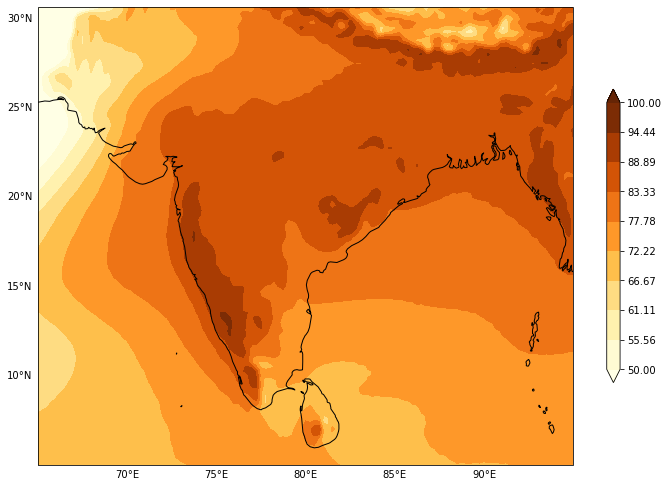

In [26]:
figure = plt.figure(figsize=[12, 12])

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines =False
ax.set_extent([65,95,5,30])

v = np.linspace(50, 100, 10, endpoint=True)
var_fill = ax.contourf(era5_ecmwf_lons, era5_ecmwf_lats, era5_ecmwf_rh, v, cmap = plt.cm.YlOrBr, extend = 'both',
                       transform=ccrs.PlateCarree(),
                       )
plt.colorbar(var_fill, shrink = .45)

In [24]:
ecmwf_ds = xarray.open_dataset("/global/cscratch1/sd/salilg/rh_era5_ecmwf_tenday/ecmwf_rh_files/output_slice_averaged_ecmwf.nc")
ecmwf_lats = ecmwf_ds.lat
ecmwf_lons = ecmwf_ds.lon
ecmwf_rh = ecmwf_ds.rh[0]
ecmwf_ds.close()

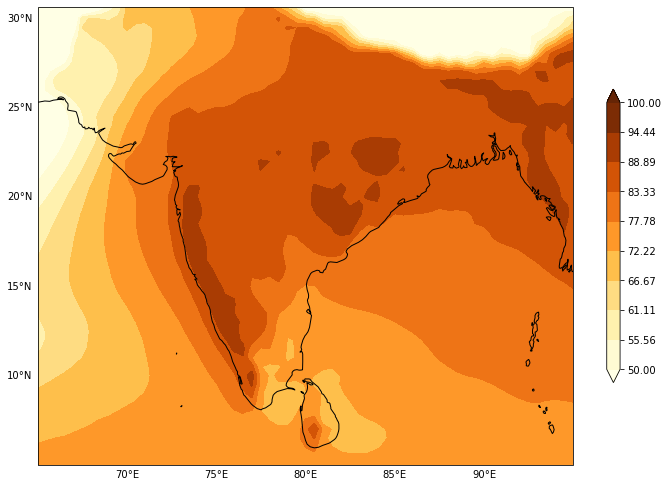

In [28]:
figure = plt.figure(figsize=[12, 12])

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines =False
ax.set_extent([65,95,5,30])

v = np.linspace(50, 100, 10, endpoint=True)
var_fill = ax.contourf(ecmwf_lons, ecmwf_lats, ecmwf_rh, v, cmap = plt.cm.YlOrBr, extend = 'both',
                       transform=ccrs.PlateCarree(),
                       )
plt.colorbar(var_fill, shrink = .45)

In [25]:
era5_ecmwf_rh_interpolated = era5_ecmwf_rh.interp_like(ecmwf_rh)

Text(0.5, 1.0, 'ECMWF Relative Humidity Bias, all timesteps averaged')

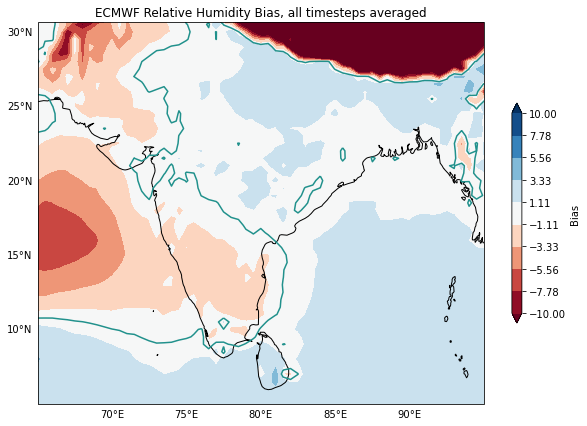

In [26]:
figure = plt.figure(figsize=[10, 9])

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines =False
ax.set_extent([65,95,5,30])

ax.contour(ecmwf_lons, ecmwf_lats, ecmwf_rh - era5_ecmwf_rh_interpolated, 0, extend ='both')
v = np.linspace(-10, 10, 10, endpoint=True)
var_fill = ax.contourf(ecmwf_lons, ecmwf_lats, ecmwf_rh - era5_ecmwf_rh_interpolated, v, cmap = plt.cm.RdBu, extend = 'both',
                       transform=ccrs.PlateCarree(),
                       )
plt.colorbar(var_fill, shrink = .45).set_label('Bias')

ax.set_title('ECMWF Relative Humidity Bias, all timesteps averaged')


# IITM vs ERA5 Genesis

## prepare the ERA5 data to be plotted

In [19]:
'''ONLY GOTTA DO THIS ONCE; IT's ALREADY DONE. DOn't RUN AGAIN UNLESS THERE WAS AN ERROR AND NEED TO REDO.

years = ['2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018'] #will probably need to do this one by one because it does it really slowly for each year

for year in years:
    
    file = '/global/project/projectdirs/m3310/vishnu/LPS_detetction_data/ERA5/rh850_' + year + '.nc'
    ds = xarray.open_dataset(file)
    
    for date in dates:
        if date[:4] == year:
            #if date != dates[0] and date[:4] == year:

            firstDay = date

            firstDayForSlicing = firstDay[:4] + '-' + firstDay[4:6] + '-' + firstDay[6:8] + 'T00:00'
            lastDayForSlicing = firstDay[:4] + '-' + firstDay[4:6] + '-' + firstDay[6:8] + 'T00:00'

            genesisSlice = ds.sel(time=slice(firstDayForSlicing, lastDayForSlicing))
            %time genesisSlice.to_netcdf("/global/cscratch1/sd/salilg/rh_era5_iitm_genesis/era5_genesis_for_iitm_rh_files/slice_" + date + ".nc", 'w')

    ds.close()
'''

In [ ]:
'''
NOTE:
- to get output_slice_averaged.nc, the following was done in the command line:
    1. cdo ensmean slice_* output_slice.nc [where output_slice.nc is the output file]
    don't need to do cdo timmean b/c it's just one timestep anyways.
'''

## plot the data

In [27]:
era5_iitm_genesis_ds = xarray.open_dataset("/global/cscratch1/sd/salilg/rh_era5_iitm_genesis/era5_genesis_for_iitm_rh_files/output_slice_averaged.nc")
era5_iitm_genesis_ds.close()

In [28]:
#because the IITM data is not for the whole world, just for a large rectangle around India, need to select only that area of ERA5
era5_iitm_genesis_ds_new = era5_iitm_genesis_ds.sel(lon = slice(40, 120)).sel(lat = slice(40, -30))

In [29]:
era5_iitm_genesis_lats = era5_iitm_genesis_ds_new.lat
era5_iitm_genesis_lons = era5_iitm_genesis_ds_new.lon
era5_iitm_genesis_rh = era5_iitm_genesis_ds_new.RH[0]

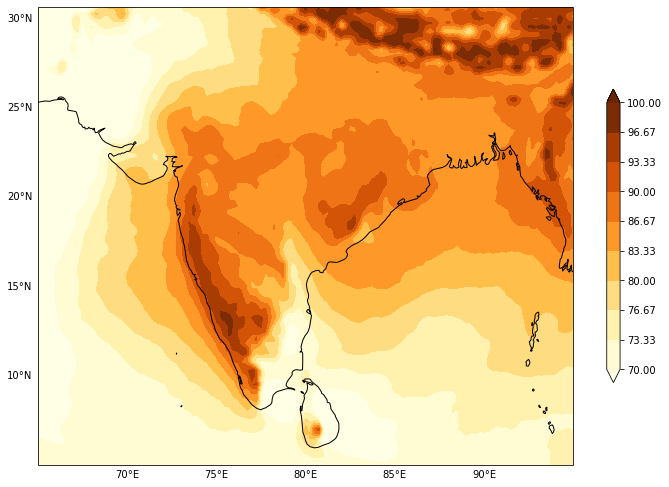

In [36]:
figure = plt.figure(figsize=[12, 12])

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
#ax.set_extent(axisExtent)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines =False
ax.set_extent([65,95,5,30])

#ax.contour(lons, lats, era5_rh, vmax = 90)
v = np.linspace(70, 100, 10, endpoint=True)
var_fill = ax.contourf(era5_iitm_genesis_lons, era5_iitm_genesis_lats, era5_iitm_genesis_rh, v, cmap = plt.cm.YlOrBr, extend = 'both',
                       transform=ccrs.PlateCarree(),
                       )
plt.colorbar(var_fill, shrink = .45)

In [30]:
iitm_genesis_ds = xarray.open_dataset("first_timestep.nc")
iitm_genesis_lats = iitm_genesis_ds.latitude
iitm_genesis_lons = iitm_genesis_ds.longitude
iitm_genesis_rh = iitm_genesis_ds.RH_850mb[0]
iitm_genesis_ds.close()

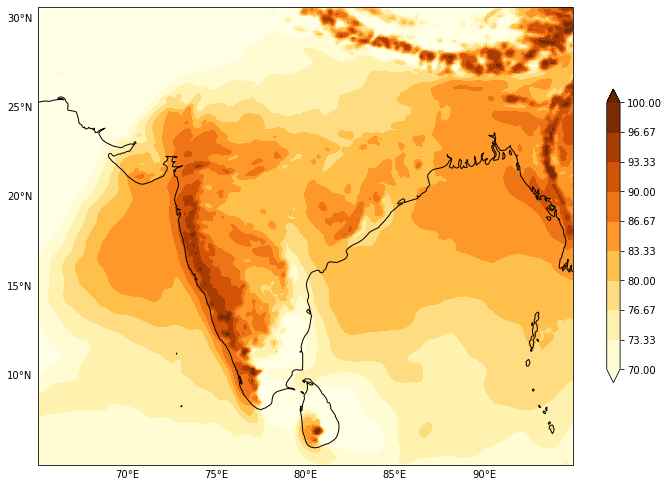

In [38]:
figure = plt.figure(figsize=[12, 12])

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
#ax.set_extent(axisExtent)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines =False
ax.set_extent([65,95,5,30])

v = np.linspace(70, 100, 10, endpoint=True)
var_fill = ax.contourf(iitm_genesis_lons, iitm_genesis_lats, iitm_genesis_rh, v, cmap = plt.cm.YlOrBr, extend = 'both',
                       transform=ccrs.PlateCarree(),
                       )
plt.colorbar(var_fill, shrink = .45)

In [31]:
iitm_genesis_rh = iitm_genesis_rh.rename({'longitude': 'lon','latitude': 'lat'})

In [32]:
iitm_genesis_rh_interpolated = iitm_genesis_rh.interp_like(era5_iitm_genesis_rh)

Text(0.5, 1.0, 'IITM Relative Humidity Bias, at genesis')

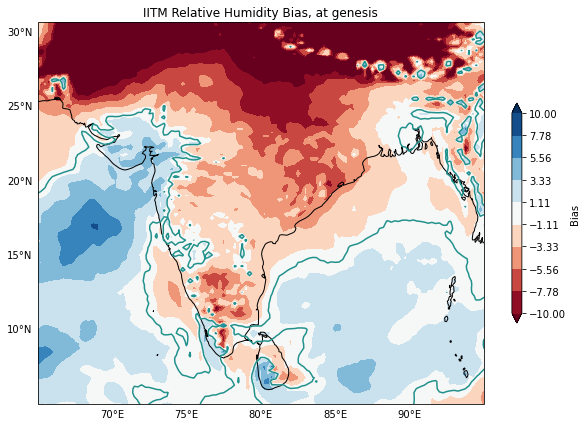

In [33]:
figure = plt.figure(figsize=[10, 9])

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines =False
ax.set_extent([65,95,5,30])

ax.contour(era5_iitm_genesis_lons, era5_iitm_genesis_lats, iitm_genesis_rh_interpolated - era5_iitm_genesis_rh, 0, extend ='both')
v = np.linspace(-10, 10, 10, endpoint=True)
var_fill = ax.contourf(era5_iitm_genesis_lons, era5_iitm_genesis_lats, iitm_genesis_rh_interpolated - era5_iitm_genesis_rh, v, cmap = plt.cm.RdBu, extend = 'both',
                       transform=ccrs.PlateCarree(),
                       )
plt.colorbar(var_fill, shrink = .45).set_label('Bias')
ax.set_title('IITM Relative Humidity Bias, at genesis')


# ECMWF vs ERA5 Genesis

## prepare the ecmwf data

In [35]:
#first copy all the rh files to a separate directory
for date in genFor:
    if date[:4] != '2019':
        #just get the genesis point
        file = '/global/cscratch1/sd/salilg/' + date[:4] + '/rh_data_' + date + '.nc'
        ecmwf_genesis_ds = xarray.open_dataset(file)
        genesis_Slice = ecmwf_genesis_ds.isel(time=[0])
        genesis_Slice.to_netcdf("/global/cscratch1/sd/salilg/rh_era5_ecmwf_genesis/ecmwf_genesis_rh_files/slice_" + date + ".nc", "w")
        ecmwf_genesis_ds.close()
'''
NOW: go into the command line and run the following:
    1. cdo ensmean rh_data_* output_slice_ecmwf.nc [where output_slice.nc is the output file]
'''

#ECMWF data is now ready to plot

'\nNOW: go into the command line and run the following:\n    1. cdo ensmean rh_data_* output_slice_ecmwf.nc [where output_slice.nc is the output file]\n    2. cdo timmean output_slice_ecmwf.nc output_slice_averaged_ecmwf.nc\n'

## prepare the era5 data corresponding to this ecmwf data

In [42]:
#ONLY DO THIS ONCE; HAS ALREADY BEEN DONE

years = ['2007', '2008']

for year in years:
    
    file = '/global/project/projectdirs/m3310/vishnu/LPS_detetction_data/ERA5/rh850_' + year + '.nc'
    ds = xarray.open_dataset(file)
    
    for date in genObs:
        if date in genFor and date[:4] == year and int(date[4:]) < 920: #want dates before 09/20 so that we can get a full ten day forecast

            firstDay, firstHour = convertGenObsToDate(genObs[date])

            firstDayForSlicing = firstDay[:4] + '-' + firstDay[4:6] + '-' + firstDay[6:8] + 'T' + firstHour + ':00'
            lastDayForSlicing = firstDay[:4] + '-' + firstDay[4:6] + '-' + firstDay[6:8] + 'T' + firstHour + ':00'

            tenDaySlice = ds.sel(time=slice(firstDayForSlicing, lastDayForSlicing))
            tenDaySlice.to_netcdf("/global/cscratch1/sd/salilg/rh_era5_ecmwf_genesis/era5_genesis_for_ecmwf_rh_files/slice_" + date + ".nc", 'w')
            #runningTotal = xarray.merge([runningTotal, tenDaySlice])
            
    ds.close()

#DOn't NEED TO DO

In [ ]:
'''
NOW: go into the command line and run the following:
    1. cdo ensmean slice_* output_slice_era5_for_ecmwf_[insert].nc [where output_slice.nc is the output file]
'''

## plot the data

In [34]:
era5_ecmwf_genesis_ds = xarray.open_dataset("/global/cscratch1/sd/salilg/rh_era5_ecmwf_genesis/era5_genesis_for_ecmwf_rh_files/output_slice_era5_genesis_for_ecmwf.nc")
era5_ecmwf_genesis_lats = era5_ecmwf_genesis_ds.lat
era5_ecmwf_genesis_lons = era5_ecmwf_genesis_ds.lon
era5_ecmwf_genesis_rh = era5_ecmwf_genesis_ds.RH[0]
era5_ecmwf_genesis_ds.close()

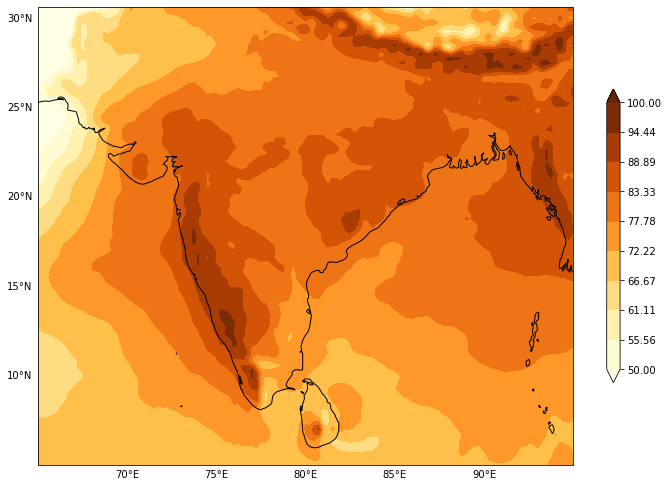

In [45]:
figure = plt.figure(figsize=[12, 12])

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines =False
ax.set_extent([65,95,5,30])

v = np.linspace(50, 100, 10, endpoint=True)
var_fill = ax.contourf(era5_ecmwf_genesis_lons, era5_ecmwf_genesis_lats, era5_ecmwf_genesis_rh, v, cmap = plt.cm.YlOrBr, extend = 'both',
                       transform=ccrs.PlateCarree(),
                       )
plt.colorbar(var_fill, shrink = .45)

In [35]:
ecmwf_genesis_ds = xarray.open_dataset("/global/cscratch1/sd/salilg/rh_era5_ecmwf_genesis/ecmwf_genesis_rh_files/output_slice_ecmwf_genesis.nc")
ecmwf_genesis_lats = ecmwf_genesis_ds.lat
ecmwf_genesis_lons = ecmwf_genesis_ds.lon
ecmwf_genesis_rh = ecmwf_genesis_ds.rh[0]
ecmwf_genesis_ds.close()

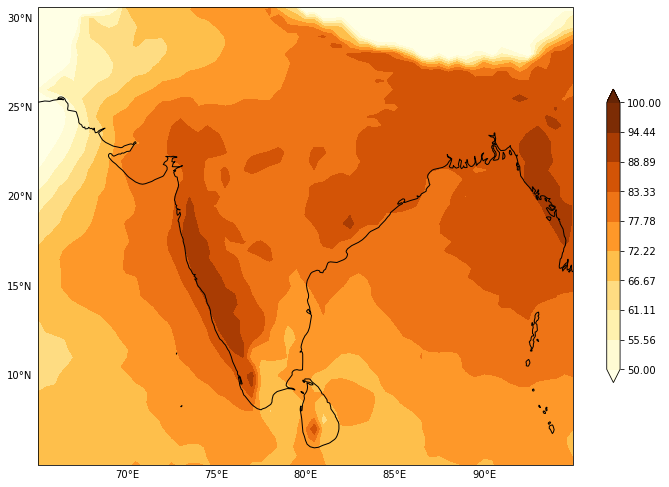

In [47]:
figure = plt.figure(figsize=[12, 12])

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines =False
ax.set_extent([65,95,5,30])

v = np.linspace(50, 100, 10, endpoint=True)
var_fill = ax.contourf(ecmwf_genesis_lons, ecmwf_genesis_lats, ecmwf_genesis_rh, v, cmap = plt.cm.YlOrBr, extend = 'both',
                       transform=ccrs.PlateCarree(),
                       )
plt.colorbar(var_fill, shrink = .45)

In [36]:
era5_ecmwf_genesis_rh_interpolated = era5_ecmwf_genesis_rh.interp_like(ecmwf_genesis_rh)

Text(0.5, 1.0, 'ECMWF Relative Humidity Bias, at genesis')

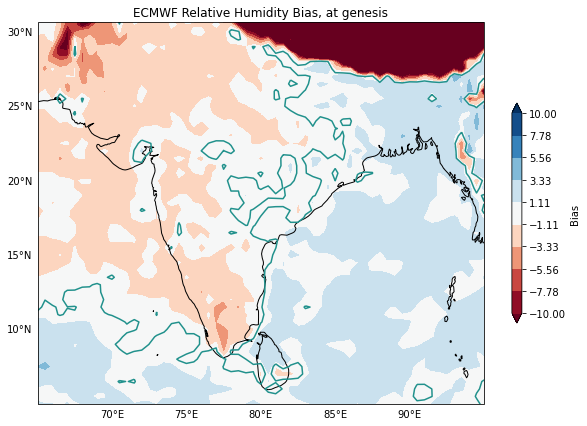

In [37]:
figure = plt.figure(figsize=[10, 9])

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines =False
ax.set_extent([65,95,5,30])

ax.contour(ecmwf_genesis_lons, ecmwf_genesis_lats, ecmwf_genesis_rh - era5_ecmwf_genesis_rh_interpolated, 0, extend ='both')
v = np.linspace(-10, 10, 10, endpoint=True)
var_fill = ax.contourf(ecmwf_genesis_lons, ecmwf_genesis_lats, ecmwf_genesis_rh - era5_ecmwf_genesis_rh_interpolated, v, cmap = plt.cm.RdBu, extend = 'both',
                       transform=ccrs.PlateCarree(),
                       )
plt.colorbar(var_fill, shrink = .45).set_label('Bias')
ax.set_title('ECMWF Relative Humidity Bias, at genesis')


# in one figure

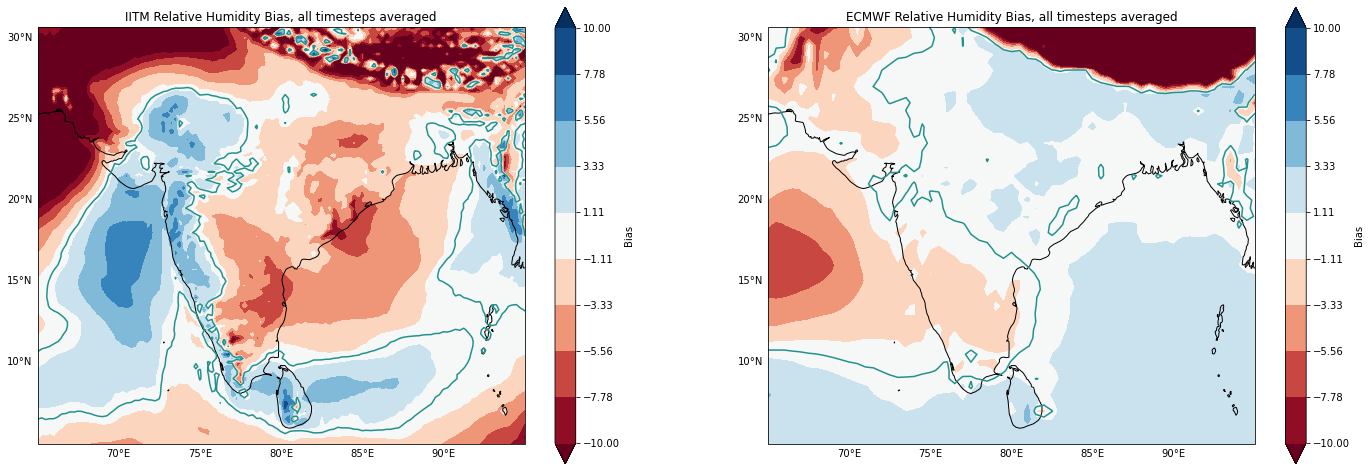

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=[24, 24])

# IITM, all timesteps averaged

ax1.coastlines()
gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl1.top_labels = False
gl1.right_labels = False
gl1.xlines = False
gl1.ylines =False
ax1.set_extent([65,95,5,30])

ax1.contour(era5_iitm_lons, era5_iitm_lats, iitm_rh_interpolated - era5_iitm_rh, 0, extend ='both')
v_1 = np.linspace(-10, 10, 10, endpoint=True)
var_fill_1 = ax1.contourf(era5_iitm_lons, era5_iitm_lats, iitm_rh_interpolated - era5_iitm_rh, v_1, cmap = plt.cm.RdBu, extend = 'both',
                       transform=ccrs.PlateCarree(),
                       )
plt.colorbar(var_fill_1, shrink = .35, ax=ax1).set_label('Bias')

ax1.set_title('IITM Relative Humidity Bias, all timesteps averaged')

# ECMWF, all timesteps averaged

ax2.coastlines()
gl2 = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl2.top_labels = False
gl2.right_labels = False
gl2.xlines = False
gl2.ylines =False
ax2.set_extent([65,95,5,30])

ax2.contour(ecmwf_lons, ecmwf_lats, ecmwf_rh - era5_ecmwf_rh_interpolated, 0, extend ='both')
v_2 = np.linspace(-10, 10, 10, endpoint=True)
var_fill_2 = ax2.contourf(ecmwf_lons, ecmwf_lats, ecmwf_rh - era5_ecmwf_rh_interpolated, v_2, cmap = plt.cm.RdBu, extend = 'both',
                       transform=ccrs.PlateCarree(),
                       )
plt.colorbar(var_fill_2, shrink = .35, ax=ax2).set_label('Bias')

ax2.set_title('ECMWF Relative Humidity Bias, all timesteps averaged')

plt.savefig('Figures/RH_bias_all_timesteps.pdf', format='pdf', bbox_inches='tight')